# 🚀 Lab 4: GANs and Autoencoders — A Generative Modeling Discovery Journey

###Instructor: Dr. Andrea Ramirez-Salgado

## Welcome, Deep Learning Explorer!

In this lab, you'll step into the world of **generative models** — neural networks that don't just classify or predict, but *create*. You'll build systems that learn to generate realistic images from pure noise (GANs) and compress images into compact representations then reconstruct them (Autoencoders). By the end, you'll understand two of the most powerful paradigms in modern deep learning.

### 🎯 What You'll Discover
- How GANs pit two networks against each other in a creative adversarial game
- How Autoencoders learn compressed representations of data (and why that matters)
- The architectural building blocks behind image generation
- How to diagnose, visualize, and debug generative model training
- Real-world applications: from art generation to anomaly detection

### 🧪 Your Lab Philosophy
1. **Experiment First**: Try things, make mistakes, learn from them
2. **Visualize Everything**: See what's happening under the hood
3. **Connect Concepts**: Understand the "why" behind the "what"

### 📊 Your Progress Tracker
Throughout this lab, you'll complete:
- 🔵 **Discovery Tasks**: Explore and experiment with generative concepts
- 🟢 **Implementation Tasks**: Build real generative model components
- 🟡 **Reflection Tasks**: Deepen your understanding of *why* things work
- 🔴 **Challenge Tasks**: Push your boundaries with creative applications

**Pro Tip**: Don't rush! Generative models are fascinating — take time to *look* at what your networks create and think about what's happening. The goal is understanding, not completion speed.

---

Let's begin! 🎓

## 🛠️ Setup: Your Generative Modeling Toolkit

### Installation Recommendation
If you haven't already, make sure you have a dedicated deep learning environment:

```bash
conda create -n deep-learning python=3.9
conda activate deep-learning
conda install pytorch torchvision -c pytorch
conda install matplotlib numpy jupyter seaborn scikit-learn
pip install opencv-python
```

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ GPU available: {torch.cuda.is_available()}")
print(f"✅ Using device: {device}")
print("\n🎉 You're all set! Let's dive into generative models!")

✅ PyTorch version: 2.2.1+cpu
✅ GPU available: False
✅ Using device: cpu

🎉 You're all set! Let's dive into generative models!


---

# Part 1: CNN Foundations on CIFAR-10 🏗️

## Why This Matters

Before we dive into *generating* images, we need a strong foundation in how neural networks *understand* images. The CNN you'll build here is the same kind of feature extractor that powers the discriminator in a GAN and the encoder in an autoencoder. Think of it this way: you need to understand how a critic evaluates art before you can appreciate how a forger learns to fool them.

In this part, you'll train a CNN classifier on CIFAR-10, then peek inside its brain using advanced visualization techniques like Grad-CAM. This will give you intuition for *what features networks learn* — essential context for understanding generative models.

### ⚡ A Note on Training Time

We run the CNN for **only 1 epoch** here as a **sanity check** — enough to verify the architecture works and to see early-stage learned features, but nowhere near enough for good accuracy. With 1 epoch you'll see ~40-50% accuracy (random guessing on 10 classes is 10%). This is expected! The CNN architecture itself can reach 90%+ accuracy with 50-100 epochs. Feel free to increase `num_epochs` if you have GPU time, but the focus here is understanding the *architecture and features*, not chasing accuracy — because those same architectural patterns show up in GANs and autoencoders.

### 🔵 Discovery Task 1: Understanding What CNNs See

**Your Mission**: Train the CNN below (provided for you), then explore what it learns internally. Even after just 1 epoch, the network has already started learning meaningful filters! Pay close attention to how the network progressively extracts more complex features — this same principle drives both GANs and autoencoders.

In [4]:
# =============================================================================
# 1.1 Data Loading and Preprocessing
# =============================================================================
# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])
# For testing/validation: only convert to tensor and normalize.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

# Download CIFAR-10 datasets.
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create a validation split (10% of training data)
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"✅ Training samples: {len(train_dataset)}")
print(f"✅ Validation samples: {len(val_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
✅ Training samples: 45000
✅ Validation samples: 5000
✅ Test samples: 10000


In [5]:
# =============================================================================
# 1.2 Define the Advanced CNN Model
# =============================================================================
class AdvancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(AdvancedCNN, self).__init__()
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),                             
            nn.ReLU(inplace=True),                          
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  
            nn.Dropout(0.2)
        )
        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

model = AdvancedCNN(num_classes=10).to(device)
print(model)

AdvancedCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, s

Epoch [1/1] Train Loss: 2.3066, Train Acc: 0.0994 | Val Loss: 2.3073, Val Acc: 0.0942

Test Loss: 2.3058, Test Accuracy: 0.1000
📌 Remember: This is a 1-epoch sanity check. Accuracy will be low (~40-50%).
   With 50+ epochs this architecture can reach 90%+ accuracy.


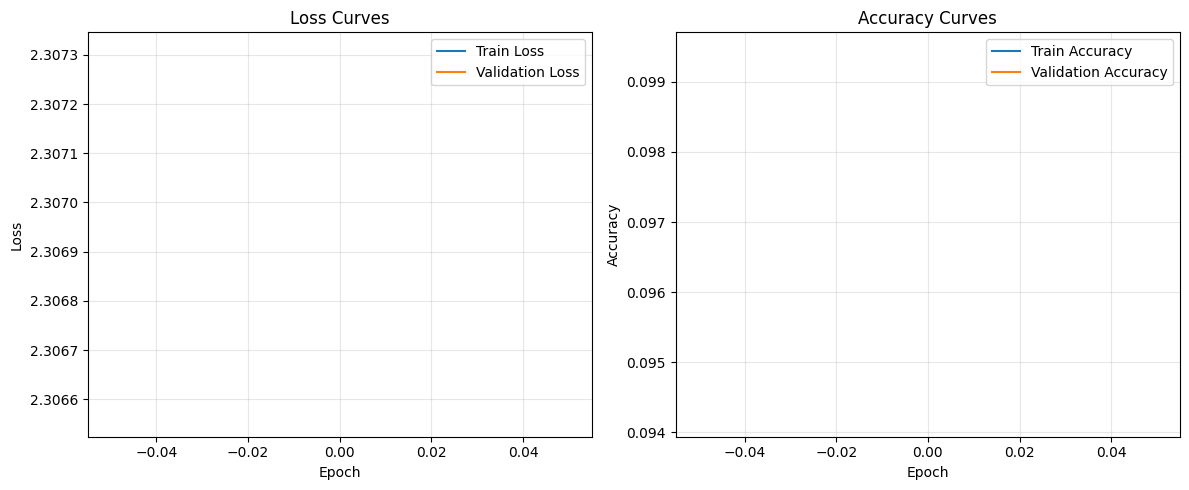

In [7]:
# =============================================================================
# 1.3 Training Strategies and Optimization
# =============================================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

# Early Stopping Setup
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 1  # ⚡ Sanity check only! Increase to 50-100 for real performance (~90%+ accuracy).
# With 1 epoch expect ~40-50% accuracy — this is normal and expected.
# The goal here is to verify the architecture and examine learned features, not to achieve high accuracy.
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss = val_running_loss / total_val
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early Stopping Check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break

# Load the best model state
model.load_state_dict(best_model_state)

# =============================================================================
# 1.4 Evaluate the Model on the Test Set
# =============================================================================
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_loss /= total_test
test_acc = correct_test / total_test
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
print(f"📌 Remember: This is a 1-epoch sanity check. Accuracy will be low (~40-50%).")
print(f"   With 50+ epochs this architecture can reach 90%+ accuracy.")

# Plot training and validation curves.
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 🔵 Discovery Task 2: Peering Inside the CNN's Brain

The following code performs advanced visualizations to help you understand *what* the CNN has learned. You'll see:
- **Convolutional filters**: The raw patterns the network looks for
- **Grad-CAM heatmaps**: Which parts of an image drive the network's decisions

**Even after just 1 epoch**, the first convolutional layer has already started learning edge and color detectors — these are fundamental building blocks that emerge very early in training. Deeper layers will look more random at this stage because they need more training to specialize. As you examine these, think about how this relates to generative models: the *discriminator* in a GAN learns similar features to decide if an image is real or fake, and the *encoder* in an autoencoder learns what information is most important to preserve.

### 🔵 Discovery Task 2b: What Changes With More Training? *(Optional)*

If you have GPU access, try increasing `num_epochs` to 10 or 20 in the training cell above and re-running. Compare the filters before and after — you should see deeper layers develop more structured, meaningful patterns. This is exactly the kind of feature learning that makes the Discriminator in a GAN increasingly hard to fool.

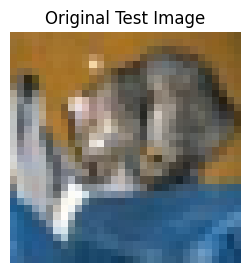

🔍 Filters from conv_block1 (edges, colors):


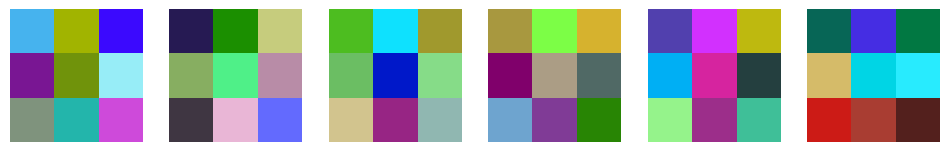

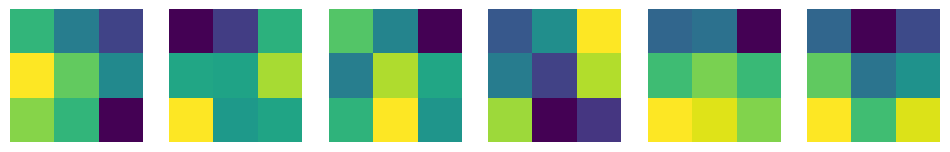

🔍 Filters from conv_block2 (textures, patterns):


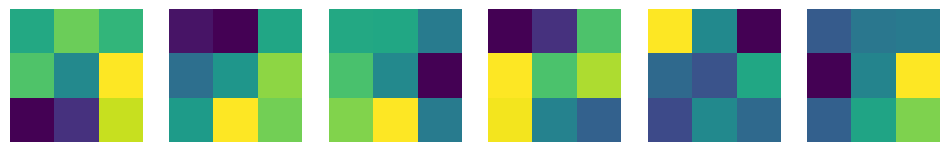

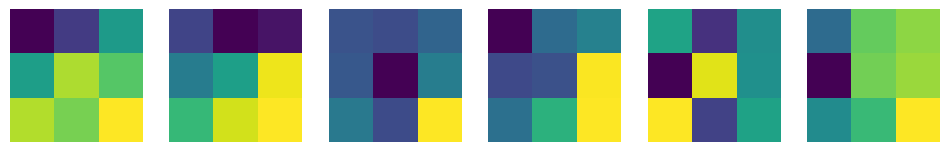

🔍 Filters from conv_block3 (complex features, object parts):


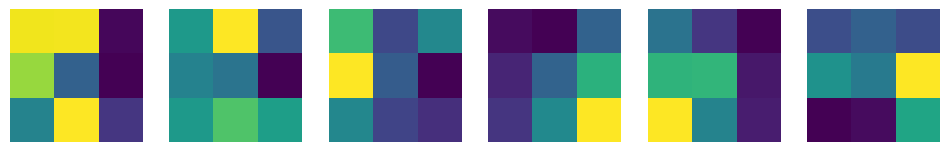

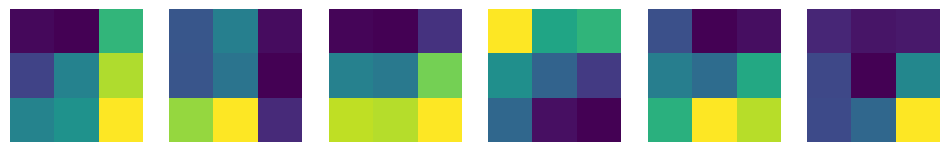

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


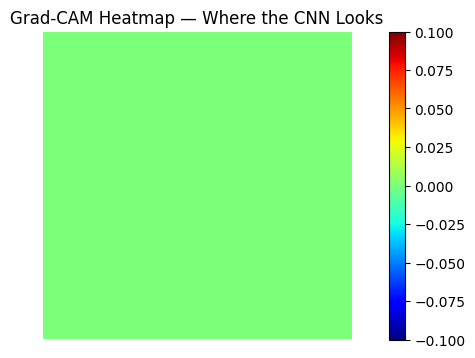

In [8]:
import cv2

# CIFAR-10 normalization parameters
cifar_mean = np.array([0.4914, 0.4822, 0.4465])
cifar_std  = np.array([0.2470, 0.2435, 0.2616])

def unnormalize(img_tensor, mean, std):
    """Reverses normalization to restore original image values for visualization."""
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Retrieve a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show original test image
orig_img_tensor = images[0].cpu()
orig_img = unnormalize(orig_img_tensor, cifar_mean, cifar_std)

plt.figure(figsize=(3,3))
plt.imshow(orig_img)
plt.title("Original Test Image")
plt.axis("off")
plt.show()

# ---------------------------------------------------------------------------
# Visualize Trained Filters in Each Convolutional Layer
# ---------------------------------------------------------------------------
def plot_conv_filters(conv_layer, num_filters=6):
    """Visualizes filters from a convolutional layer."""
    filters = conv_layer.weight.data.clone().cpu()
    n_filters = min(num_filters, filters.shape[0])
    
    fig, axes = plt.subplots(1, n_filters, figsize=(n_filters*2, 2))
    for i in range(n_filters):
        filt = filters[i]
        if filt.shape[0] == 3:
            filt = filt.numpy().transpose(1, 2, 0)
            filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
        else:
            filt = filt.mean(0).numpy()
            filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
        axes[i].imshow(filt, cmap='viridis')
        axes[i].axis('off')
    plt.show()

print("🔍 Filters from conv_block1 (edges, colors):")
for layer in model.conv_block1:
    if isinstance(layer, nn.Conv2d):
        plot_conv_filters(layer, num_filters=6)

print("🔍 Filters from conv_block2 (textures, patterns):")
for layer in model.conv_block2:
    if isinstance(layer, nn.Conv2d):
        plot_conv_filters(layer, num_filters=6)

print("🔍 Filters from conv_block3 (complex features, object parts):")
for layer in model.conv_block3:
    if isinstance(layer, nn.Conv2d):
        plot_conv_filters(layer, num_filters=6)

# ---------------------------------------------------------------------------
# Grad-CAM Visualization
# ---------------------------------------------------------------------------
class GradCAM:
    """Grad-CAM: Visualize which image regions drive classification decisions."""
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))
    
    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        loss.backward()
        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam
    
    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

target_layer = model.conv_block3[3]
grad_cam = GradCAM(model, target_layer)

cam_map = grad_cam.generate(images[0:1].to(device))
cam_map = cam_map.cpu().squeeze().numpy()

cam_map_up = cv2.resize(cam_map, (32, 32))
cam_map_up = np.uint8(255 * cam_map_up)
cam_heatmap = cv2.applyColorMap(cam_map_up, cv2.COLORMAP_JET)

plt.figure(figsize=(10, 4))
plt.imshow(cam_map, cmap='jet')
plt.title("Grad-CAM Heatmap — Where the CNN Looks")
plt.axis("off")
plt.colorbar()
plt.show()
grad_cam.remove_hooks()

### 🟡 Reflection 1: From Classification to Generation

Now that you've seen how a CNN classifier works from the inside, let's connect this to generative models.

1. **The filters you visualized** progress from simple (edges, colors) to complex (object parts). How might a *generator* network need to reverse this process — going from abstract concepts to concrete pixels?

*Your answer:*
When I think about the CNN filters I visualized, I see them as a ladder from simple to complex: the early layers pick up basic edges and colors, the middle layers start to detect shapes and parts, and the later layers capture high‑level concepts like “this looks like a dog.” A generator feels like it has to run this ladder in reverse. Instead of starting from pixels and climbing up to an abstract class, it starts from a compact, abstract code (the latent vector) and gradually turns that into something that looks like a real image. The first layers of the generator can be thought of as sketching the rough layout and structure, and as we go deeper, the network fills in more precise shapes, textures, and colors until we end up with detailed pixels. So the generator is essentially learning how to go from “concept space” back down to the raw image space in a way that mirrors a classifier but in the opposite direction.

2. **Grad-CAM showed you** which regions matter most for classification. If you were building a discriminator for a GAN, what kind of features do you think it would learn to look for to distinguish real from fake images?

*Your answer:*
Grad‑CAM helped me see which regions of an image a classifier cares about when making its decision. If I translate that intuition to a GAN discriminator, I imagine it learning to focus on whatever makes an image look genuinely “real.” That includes global structure (are the objects the right shape and in the right place?), but also a lot of subtle low‑level details: are the edges clean, are the textures believable, do the colors and lighting look consistent, or are there strange artifacts or patterns that give it away as fake? Over time, the discriminator would become very sensitive to those small inconsistencies that humans also notice when something “looks off,” and it would use those cues to separate real images from the ones the generator is producing.

3. **The encoder-decoder connection**: The CNN compresses a 32×32×3 image into a 4×4×128 feature map before classification. An autoencoder does something similar but then *reconstructs* the image. What information do you think gets lost in this compression, and what gets preserved?

*Your answer:*
When the CNN compresses a 32×32×3 image down to a 4×4×128 feature map, it clearly cannot keep every pixel‑level detail. What tends to be preserved is the information that matters for recognizing what’s in the image: the overall layout, the main shapes, the important edges, and a rough sense of color and texture. What gets lost are the exact values of individual pixels, very fine textures, and background details that don’t really affect the label. An autoencoder does something very similar: it pushes the image through a bottleneck and then tries to reconstruct it. Because the bottleneck is limited, it prioritizes preserving the global structure and main appearance of the object, and as a result, reconstructions can look a bit smoother or blurrier. That’s a hint that tiny, high‑frequency details are what get sacrificed during compression, while the core content and structure are what survive.


4. **1-epoch reality check**: The CNN accuracy after 1 epoch is much lower than what this architecture can achieve. Why does deep learning require many epochs over the same data? What is improving during each additional pass through the dataset?

*Your answer:*
The low accuracy after just one epoch is a good reminder that deep learning models usually need to see the data many times before they really “understand” it. Each epoch is just one full pass where the model updates its weights a little bit based on the gradients from each mini‑batch. In the first epoch, those updates are still very rough; the filters are just starting to align with useful patterns. With every additional epoch, the model keeps refining its filters and decision boundaries, reducing the loss, and correcting mistakes it made on previous passes. In other words, what improves over multiple epochs is the quality of the internal representations and the fit between the model and the data distribution. One epoch is more like a first draft; after many passes, the network has had enough opportunities to adjust and converge to a much better solution.


---

# Part 2: Generative Adversarial Networks (GANs) 🎭

## Why This Matters

Imagine two people: an **art forger** who's learning to paint convincing fakes, and an **art detective** who's learning to spot them. As the detective gets better, the forger must improve too. As the forger gets better, the detective must sharpen their skills. This escalating competition is *exactly* how a GAN works.

GANs are behind some of the most impressive AI achievements: photorealistic face generation (StyleGAN), image-to-image translation (pix2pix), super-resolution, and even drug discovery. Understanding how they work gives you access to one of the most powerful creative tools in deep learning.

**The key insight**: Instead of explicitly defining what a "good" image looks like (which is incredibly hard), we train a neural network to *learn* what "good" means by looking at real data — and then use that learned judgment to guide another network that creates new images.

### The GAN Game in One Sentence
> The **Generator** tries to create images that fool the **Discriminator**, while the **Discriminator** tries to correctly identify real images from fake ones.

### ⚡ What to Expect From Training

We'll run the GAN for **1 epoch by default** as a quick demo. With 1 epoch on CIFAR-10, your generated images will look like blurry, noisy textures — that's completely normal! Real DCGAN training takes **25-50 epochs with a GPU** to produce recognizable objects. The learning goal here is to **understand the training dynamics**: watch how D(x) and D(G(z)) evolve, interpret the loss curves, and identify signs of training stability or instability. If you have GPU time, increase `num_epochs_GAN` to 5-10 and watch the images progressively improve — it's one of the most satisfying things in deep learning!

---

### 🔵 Discovery Task 3: Mapping the GAN Architecture

Before coding, let's build your mental model. Study the architecture code below, then answer the questions.

**Your Mission**: Trace the flow of data through both networks. For the Generator, a random noise vector goes in — what comes out? For the Discriminator, an image goes in — what comes out?

In [9]:
# =============================================================================
# 2.1 Data Preparation for GANs
# =============================================================================

# GANs normalize to [-1, 1] range (to match Tanh output)
transform_gan = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset_gan = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_gan)
dataloader_gan = torch.utils.data.DataLoader(dataset_gan, batch_size=128, shuffle=True, num_workers=2)

# Latent space dimension — the "creative DNA" of the Generator
nz = 100  # The generator takes a 100-dimensional noise vector as input

print(f"✅ GAN dataset loaded: {len(dataset_gan)} images")
print(f"✅ Latent space dimension: {nz}")

Files already downloaded and verified
✅ GAN dataset loaded: 50000 images
✅ Latent space dimension: 100


### 🟡 Reflection 2: The GAN Data Pipeline

Before we build the networks, think about these design choices:

1. **Why [-1, 1]?** We normalized images to the range [-1, 1] instead of [0, 1]. The Generator uses Tanh as its final activation (which outputs [-1, 1]). Why is it important that the real data and generated data share the same range?

*Your answer:*
When we normalize the real images to the range [-1, 1] and the generator uses Tanh, which also outputs values in [-1, 1], we’re basically making sure both sources of images live in the same numeric space. That feels important because the discriminator is comparing real and fake images directly. If the real images were in [0, 1] and the generated ones were in [-1, 1], the discriminator could very quickly latch onto that simple difference in scale and offset instead of learning deeper visual features. By matching the ranges, we force the GAN to focus on content (shapes, textures, patterns) rather than trivial numeric differences. It also helps the generator, because its outputs don’t need extra rescaling to be comparable to the real data, which generally leads to smoother training and more stable gradients.

2. **The latent vector (nz=100)**: The Generator will take a 100-dimensional random noise vector and turn it into a 32×32×3 image (3,072 values). How is it possible to create 3,072 values from just 100 inputs? What role does the network's learned weights play?

*Your answer:*
At first, it sounds almost impossible that a 100‑dimensional noise vector can turn into a 32×32×3 image with 3,072 values, but the network isn’t just “copying” the input; it’s applying a sequence of learned transformations. Each layer of the generator has a large number of weights, and those weights define how the 100 input values get mixed, expanded, and reshaped into many more outputs. Because we stack multiple convolutional transpose layers with nonlinear activations, the network can progressively grow the spatial dimensions and the number of features while also learning complex patterns. In my head, I think of the latent vector as a compact code that tells the network what kind of image to draw, and the learned weights act like a toolkit that knows how to unpack that code into full images, filling in all 3,072 pixel values in a structured, coherent way.


### 🟢 Implementation Task 1: Build the Generator

The Generator is the "artist" — it takes random noise and learns to transform it into realistic images. Study the architecture carefully. Notice how each layer *doubles* the spatial dimensions while *halving* the number of channels, progressively building up from an abstract 4×4 representation to a full 32×32 color image.

**Think of it like painting**: Start with a rough sketch (4×4), add more detail (8×8), refine further (16×16), and finally produce the finished work (32×32).

In [11]:
# =============================================================================
# 🟢 TASK: Complete the Generator Network (DCGAN-style)
# =============================================================================
# The architecture progressively upsamples: 1x1 → 4x4 → 8x8 → 16x16 → 32x32
# 
# ARCHITECTURE GUIDE:
#   Input: noise vector of shape (batch, nz, 1, 1)
#   Layer 1: ConvTranspose2d(nz, 256, 4, 1, 0) → BatchNorm → ReLU    → (256, 4, 4)
#   Layer 2: ConvTranspose2d(256, 128, 4, 2, 1) → BatchNorm → ReLU   → (128, 8, 8)
#   Layer 3: ConvTranspose2d(128, 64, 4, 2, 1) → BatchNorm → ReLU    → (64, 16, 16)
#   Layer 4: ConvTranspose2d(64, 3, 4, 2, 1) → Tanh                   → (3, 32, 32)

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Layer 1: Project and reshape noise into a small spatial feature map
            # Input: (nz) x 1 x 1  →  Output: (256) x 4 x 4
            nn.ConvTranspose2d(nz, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # Layer 2: Upsample to 8x8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Layer 3: Upsample to 16x16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Layer 4: Final upsample to 32x32 with 3 color channels
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh() #What activation maps output to [-1, 1]?
        )
    
    def forward(self, input):
        return self.main(input)

# Test your Generator (should output shape: [1, 3, 32, 32])
test_G = Generator(nz).to(device)
test_noise = torch.randn(1, nz, 1, 1, device=device)
test_output = test_G(test_noise)
print(f"Generator output shape: {test_output.shape}")
assert test_output.shape == (1, 3, 32, 32), f"❌ Expected (1, 3, 32, 32), got {test_output.shape}"
print("✅ Generator architecture verified!")

Generator output shape: torch.Size([1, 3, 32, 32])
✅ Generator architecture verified!


### 🟡 Reflection 3: Generator Architecture Deep Dive

1. **Transpose Convolution**: Regular convolution *shrinks* spatial dimensions. Transpose convolution *grows* them. In your own words, explain why the Generator needs to grow spatial dimensions — what's it doing conceptually at each stage?

*Your answer:*
When I look at the generator’s use of transpose convolutions, I think of it as the network gradually “zooming out” the image from a tiny abstract seed. Regular convolutions usually shrink spatial dimensions, which makes sense for a classifier that wants to compress information. The generator has the opposite goal: it starts from a very small spatial representation and needs to expand it into a full 32×32 image. So at each stage, the transpose convolution is increasing the height and width while also shaping the feature maps. Conceptually, the early layers are laying down a coarse, low‑resolution sketch of the image, and as we go through more upsampling steps, the generator fills in more structure and detail. By the time we reach the final layer, the network has grown the spatial dimensions enough that each position corresponds to an actual pixel in the output image.

2. **BatchNorm in the Generator**: Why do we use BatchNorm after each transpose convolution (except the last layer)? What would happen if we removed it?

*Your answer:*
I see BatchNorm in the generator as a way to keep the activations under control while the network is trying to grow and refine the image. Each transpose convolution layer could produce outputs with very different scales, and without some kind of normalization, the activations might explode or vanish, which would make training unstable. By normalizing the activations within a batch and then learning a scale and shift, BatchNorm helps the generator maintain more consistent statistics across layers and across training steps. If we removed BatchNorm, I’d expect training to be much more fragile: the generator might collapse more easily, gradients could become very uneven, and it might be harder for it to learn smooth, coherent images. With BatchNorm, the generator can take more reliable steps in parameter space, which usually leads to better convergence and higher‑quality samples.

3. **Why Tanh and not Sigmoid?** The final layer uses Tanh (output range [-1, 1]) rather than Sigmoid (output range [0, 1]). Research or reason about why Tanh tends to work better for image generation.

*Your answer:*
For the final activation, Tanh makes more sense to me than Sigmoid in this setting. Tanh outputs values in [-1, 1], which matches the normalization we used for the input images, so there’s a nice symmetry between real and generated data. Beyond just the range, Tanh is also zero‑centered, which tends to give nicer gradients for optimization because positive and negative activations can balance each other out. Sigmoid outputs values in [0, 1] and can saturate quickly near 0 or 1, leading to very small gradients and slower learning, especially when the network is trying to produce richer contrast and variation in images. Using Tanh encourages the generator to use both positive and negative activations to represent pixel intensities, and that usually results in more stable training and more expressive image generation compared to a final Sigmoid layer.


### 🟢 Implementation Task 2: Build the Discriminator

The Discriminator is the "critic" — it takes an image (real or generated) and outputs a single probability: how likely is this image to be real? Notice how it's essentially the *mirror image* of the Generator: it takes a 32×32 image and progressively compresses it down to a single number.

**Connection to the CNN above**: The Discriminator's convolutional layers work just like the classifier's — extracting features at multiple scales. The difference is the output: instead of 10 class probabilities, it outputs one real/fake probability.

In [12]:
# =============================================================================
# 🟢 TASK: Complete the Discriminator Network
# =============================================================================
# The architecture progressively downsamples: 32x32 → 16x16 → 8x8 → 4x4 → 1x1
#
# ARCHITECTURE GUIDE:
#   Input: image of shape (batch, 3, 32, 32)
#   Layer 1: Conv2d(3, 64, 4, 2, 1) → LeakyReLU(0.2)                → (64, 16, 16)
#   Layer 2: Conv2d(64, 128, 4, 2, 1) → BatchNorm → LeakyReLU(0.2)  → (128, 8, 8)
#   Layer 3: Conv2d(128, 256, 4, 2, 1) → BatchNorm → LeakyReLU(0.2) → (256, 4, 4)
#   Layer 4: Conv2d(256, 1, 4, 1, 0) → Sigmoid                       → (1, 1, 1)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Layer 1: No BatchNorm on first layer (standard DCGAN practice)
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2: Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3: Downsample to 4x4
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4: Final classification layer
            # TODO: Fill in Conv2d parameters and activation
             nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() #What activation gives a probability between 0 and 1?
        )
    
    def forward(self, input):
        return self.main(input).view(-1)

# Test your Discriminator (should output shape: [1])
test_D = Discriminator().to(device)
test_img = torch.randn(1, 3, 32, 32, device=device)
test_out = test_D(test_img)
print(f"Discriminator output shape: {test_out.shape}")
print(f"Discriminator output value: {test_out.item():.4f} (should be between 0 and 1)")
assert 0 <= test_out.item() <= 1, "❌ Output should be between 0 and 1"
print("✅ Discriminator architecture verified!")

Discriminator output shape: torch.Size([1])
Discriminator output value: 0.3660 (should be between 0 and 1)
✅ Discriminator architecture verified!


### 🟡 Reflection 4: Discriminator Design Choices

1. **LeakyReLU vs ReLU**: The Discriminator uses LeakyReLU (allows small negative gradients) instead of ReLU (kills all negative values). Why might this be important for the Discriminator specifically? Think about what happens to gradients during backpropagation.

*Your answer:*
The choice of LeakyReLU instead of plain ReLU in the discriminator makes sense to me because of how important gradients are for learning in a GAN. With standard ReLU, any negative input gets clamped to zero, and the gradient is also zero there, which means those units can “die” and stop updating altogether. In the discriminator, that would be especially harmful: if a lot of activations go completely silent, the network might stop learning useful features and pass almost no gradient back to the generator. LeakyReLU keeps a small negative slope for negative inputs, so even when the activation is below zero, there is still a non‑zero gradient during backpropagation. That helps keep more neurons active and allows the discriminator to keep adjusting its weights, which in turn provides more informative gradients to the generator and makes the whole adversarial training process less fragile.

2. **No BatchNorm on the first layer**: DCGAN papers recommend skipping BatchNorm on the Discriminator's first layer. Why might normalizing the raw input pixels be harmful?

*Your answer:*
Skipping BatchNorm on the discriminator’s first layer also feels like a deliberate choice. The first layer is the one that sees the raw pixels directly, and its job is to start extracting low‑level features that distinguish real from fake images. If we immediately normalize those raw inputs across the batch, we might actually wash out some of the subtle differences in contrast, brightness, or local statistics that the discriminator could use as early clues. BatchNorm also introduces a dependence on the batch distribution: mixing real and fake samples in the same batch could cause their statistics to blend together in a way that makes the task harder or more unstable. By leaving the first layer without BatchNorm, we let it work directly on the original pixel values and learn its own filters, and then we can apply normalization deeper in the network where the features are more abstract and less tied to the exact input distribution

3. **Mirror architectures**: The Generator goes from small→large spatial dimensions, and the Discriminator goes large→small. Draw or describe the "information flow" in both networks. Why is this symmetry important?

*Your answer:*
When I think about the generator and discriminator architectures side by side, I picture two opposite information flows that still line up structurally. The generator starts from a small, dense latent code and progressively expands it through transpose convolutions into larger and larger spatial maps until it reaches a full 32×32 image. Information flows from “abstract idea” to detailed pixels. The discriminator does the mirror process: it takes the 32×32 image, passes it through convolutions and downsampling, and compresses it down to a single scalar that represents “real vs fake.” Information flows from raw pixels back to an abstract judgment. This symmetry is important because it means the two networks are operating on compatible representations at each scale: what the generator produces at a given resolution is exactly the kind of structure the discriminator is designed to analyze. That alignment helps stabilize training, since the discriminator is critiquing the generator at progressively similar levels of detail as the image is being built or broken down.


### 🟢 Implementation Task 3: Weight Initialization and Training Setup

Proper weight initialization is crucial for GAN training stability. Small random weights from a normal distribution prevent the networks from starting in a bad region of the loss landscape.

In [13]:
# =============================================================================
# 🟢 TASK: Initialize Networks and Set Up Training
# =============================================================================

def weights_init(m):
    """Initialize weights with a normal distribution for stable training."""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create and initialize both networks
netG = Generator(nz).to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function and optimizers
criterion = nn.BCELoss()

# TODO: Create Adam optimizers for BOTH networks
# Use lr=0.0002, betas=(0.5, 0.999) — these are proven DCGAN hyperparameters
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999)) # 🟢 YOUR CODE HERE
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))  # 🟢 YOUR CODE HERE

# Labels for real and fake images
real_label = 1.
fake_label = 0.

# Fixed noise vector to track Generator progress over time
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

print("✅ Networks initialized and ready for training!")
print(f"   Generator parameters: {sum(p.numel() for p in netG.parameters()):,}")
print(f"   Discriminator parameters: {sum(p.numel() for p in netD.parameters()):,}")

✅ Networks initialized and ready for training!
   Generator parameters: 1,068,928
   Discriminator parameters: 663,296


### 🟢 Implementation Task 4: The GAN Training Loop

This is the heart of GAN training — the adversarial game in action. Each iteration has three steps:

1. **Train Discriminator on real images** (learn to say "real" for real data)
2. **Train Discriminator on fake images** (learn to say "fake" for generated data)
3. **Train Generator** (learn to make fakes that the Discriminator says are "real")

**Critical concept — `detach()`**: When training the Discriminator on fake images, we use `.detach()` to stop gradients from flowing back to the Generator. Why? Because in step 2, we only want to update the Discriminator's weights, not the Generator's.

In [14]:
# =============================================================================
# 🟢 TASK: Complete the GAN Training Loop
# =============================================================================

num_epochs_GAN = 1  # ⚡ Quick demo: 1 epoch shows training dynamics but blurry images.
# 🎯 For visible improvement: set to 5 (clearer structure) or 25+ (recognizable objects).
# The learning goal at 1 epoch is to READ the training stats, not admire the images.
G_losses = []
D_losses = []
img_list = []

print("Starting GAN training... 🎭")
print("Watch the adversarial game unfold!\n")

for epoch in range(num_epochs_GAN):
    for i, data in enumerate(dataloader_gan, 0):
        
        # =============================================
        # STEP 1: Train Discriminator on REAL images
        # =============================================
        netD.zero_grad()
        real_images, _ = data
        b_size = real_images.size(0)
        real_images = real_images.to(device)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()  # D's confidence on real images
        
        # =============================================
        # STEP 2: Train Discriminator on FAKE images
        # =============================================
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(fake_label)
        
        # TODO: Get Discriminator's output on fake images
        # IMPORTANT: Use .detach() on fake_images! Why? (see explanation above)
        output = netD(fake_images.detach())  # 🟢 YOUR CODE HERE
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()  # D's confidence on fake images (before G update)
        
        optimizerD.step()
        
        # =============================================
        # STEP 3: Train Generator
        # =============================================
        netG.zero_grad()
        label.fill_(real_label)  # Generator wants D to think fakes are real!
        
        # TODO: Get Discriminator's output on the SAME fake images (no detach this time!)
        output = netD(fake_images) # 🟢 YOUR CODE HERE
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()  # D's confidence on fakes (after G update)
        
        optimizerG.step()
        
        # Track losses
        G_losses.append(errG.item())
        D_losses.append((errD_real + errD_fake).item())
        
        # Print progress every 100 batches
        if i % 100 == 0:
            print(f"[{epoch+1}/{num_epochs_GAN}][{i}/{len(dataloader_gan)}] "
                  f"D_loss: {(errD_real + errD_fake).item():.4f} | G_loss: {errG.item():.4f} | "
                  f"D(x): {D_x:.3f} | D(G(z)): {D_G_z1:.3f}/{D_G_z2:.3f}")
    
    # Save generated images at end of each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(torchvision.utils.make_grid(fake, padding=2, normalize=True))

print("\n✅ GAN training complete!")

Starting GAN training... 🎭
Watch the adversarial game unfold!

[1/1][0/391] D_loss: 1.4249 | G_loss: 2.3922 | D(x): 0.543 | D(G(z)): 0.497/0.111
[1/1][100/391] D_loss: 0.4883 | G_loss: 4.2443 | D(x): 0.708 | D(G(z)): 0.037/0.021
[1/1][200/391] D_loss: 0.3684 | G_loss: 4.8130 | D(x): 0.811 | D(G(z)): 0.089/0.015
[1/1][300/391] D_loss: 0.7325 | G_loss: 3.0622 | D(x): 0.589 | D(G(z)): 0.071/0.066

✅ GAN training complete!


### 📊 Visualization: GAN Training Dynamics and Results

**What to look for in the loss curves:**
- **Healthy training**: D loss hovers around 0.5–1.5, G loss around 1.0–3.0, both fluctuating
- **Discriminator winning** (common at 1 epoch): D loss drops low, G loss climbs — the Generator hasn't had enough iterations to catch up yet
- **Mode collapse** (bad): G loss drops very low while D loss rises — the Generator found one "trick" that fools D

**What to look for in the generated images:**
- At **1 epoch**: Expect colored noise/blurry textures. This is normal!
- At **5 epochs**: You should start seeing rough structure and color coherence
- At **25+ epochs**: Recognizable objects should emerge

### 🔵 Discovery Task 3b: Reading the Training Stats

Look at the printed stats during training. The key numbers are:
- **D(x)**: Discriminator's confidence that real images are real (should stay high, ~0.7-1.0)
- **D(G(z))**: Discriminator's confidence that fake images are real (starts low, should gradually increase as Generator improves)

After training, examine these values. What story do they tell about the adversarial game?

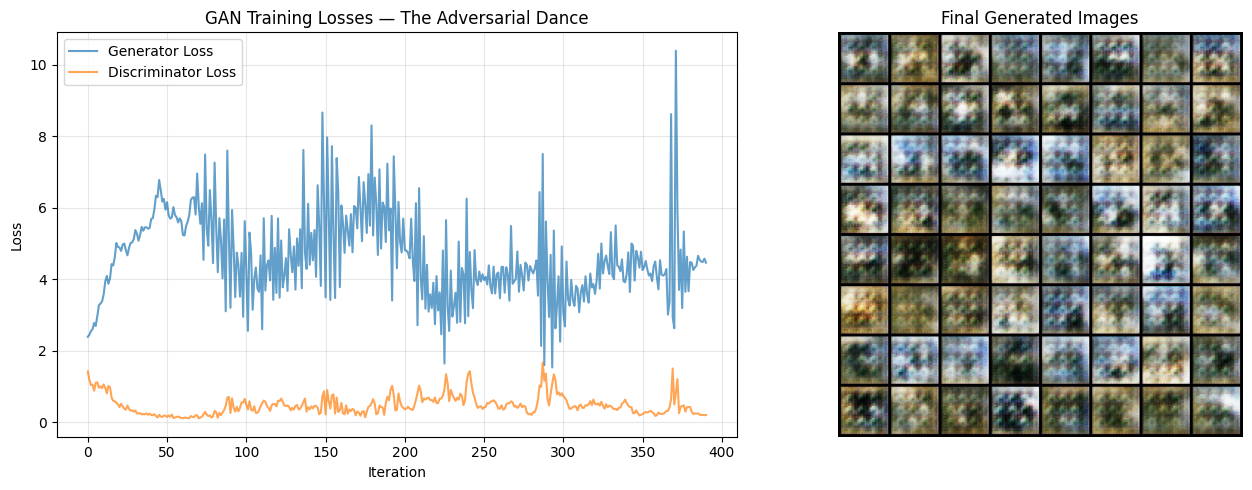

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


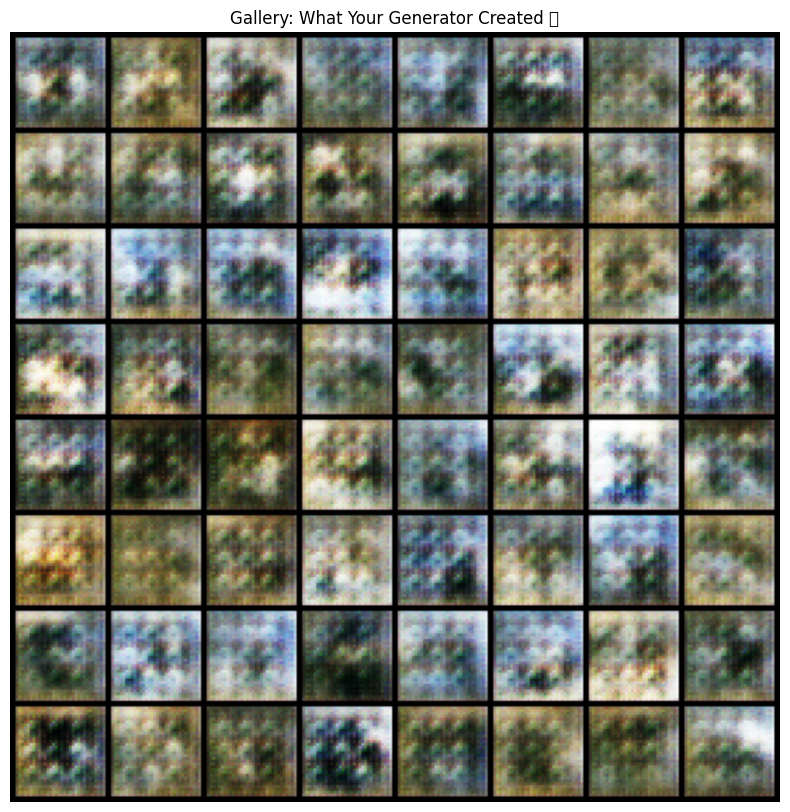

In [15]:
# =============================================================================
# Visualize GAN Training Dynamics
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(G_losses, label='Generator Loss', alpha=0.7)
axes[0].plot(D_losses, label='Discriminator Loss', alpha=0.7)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('GAN Training Losses — The Adversarial Dance')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final generated images
axes[1].axis("off")
axes[1].set_title("Final Generated Images")
if img_list:
    axes[1].imshow(np.transpose(img_list[-1], (1, 2, 0)))

plt.tight_layout()
plt.show()

# Show a larger grid of generated images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Gallery: What Your Generator Created 🎨")
with torch.no_grad():
    fake_display = netG(fixed_noise).detach().cpu()
grid = torchvision.utils.make_grid(fake_display[:64], padding=2, normalize=True, nrow=8)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

### 🧪 Experiment 1: Latent Space Exploration

One of the most fascinating properties of GANs is their **latent space** — the space of noise vectors that map to generated images. Let's explore it!

**Your Mission**: Generate images from different noise vectors and see how small changes in the noise create small changes in the output. This is called *latent space interpolation* and it reveals that the Generator has learned a smooth, meaningful representation.

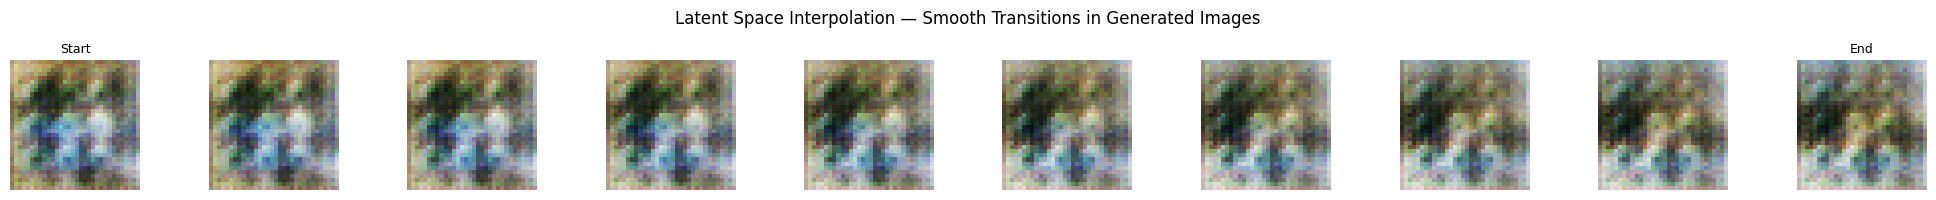

In [16]:
# =============================================================================
# 🧪 EXPERIMENT: Latent Space Interpolation
# =============================================================================

def interpolate_latent_space(netG, nz, device, n_steps=10):
    """Generate a smooth transition between two random points in latent space."""
    # Create two random starting points
    z1 = torch.randn(1, nz, 1, 1, device=device)
    z2 = torch.randn(1, nz, 1, 1, device=device)
    
    # Interpolate between them
    images = []
    for alpha in np.linspace(0, 1, n_steps):
        z = (1 - alpha) * z1 + alpha * z2  # Linear interpolation
        with torch.no_grad():
            img = netG(z).cpu()
        images.append(img.squeeze())
    
    # Display the interpolation
    fig, axes = plt.subplots(1, n_steps, figsize=(n_steps * 2, 2))
    for i, img in enumerate(images):
        img_display = (img.numpy().transpose(1, 2, 0) + 1) / 2  # [-1,1] → [0,1]
        img_display = np.clip(img_display, 0, 1)
        axes[i].imshow(img_display)
        axes[i].axis('off')
        if i == 0:
            axes[i].set_title('Start', fontsize=9)
        elif i == n_steps - 1:
            axes[i].set_title('End', fontsize=9)
    plt.suptitle('Latent Space Interpolation — Smooth Transitions in Generated Images', fontsize=12)
    plt.tight_layout()
    plt.show()

interpolate_latent_space(netG, nz, device, n_steps=10)

### 🟡 Reflection 5: Understanding GAN Training Dynamics

1. **The training dance**: Look at your loss curves. In an ideal GAN, the Discriminator loss hovers around 0.5-1.0 and the Generator loss around 1.0-2.0. If the Discriminator loss drops to nearly 0, what does that mean for the Generator? Why is this problematic?

*Your answer:*
When I look at the loss curves, I think of the GAN as a kind of tug‑of‑war between the generator and the discriminator. If the discriminator loss drops to nearly 0, that basically means it’s winning too easily: it can almost perfectly tell apart real and fake images. For the generator, this is bad news, because it means the discriminator’s output is extremely confident and the gradients the generator receives can become very small or uninformative. In that regime, the generator struggles to learn how to improve, and training can stall or become unstable. Ideally, I want the discriminator to be strong but not overpowering, so that both networks keep challenging each other and the generator still gets useful gradient signals about how to make its images more realistic.

2. **The `detach()` mystery solved**: In the training loop, we used `fake_images.detach()` when training the Discriminator but NOT when training the Generator. Explain in your own words why this is essential for the adversarial game to work correctly.

*Your answer:*
The use of fake_images.detach() in the training loop makes more sense to me when I think about which network should be updated in each step. When I’m training the discriminator, I want to treat the fake images as a fixed batch of inputs: the discriminator should learn to classify them as fake, but I don’t want those gradients to flow back into the generator at that moment. Detaching breaks the computational graph so only the discriminator’s parameters get updated. In contrast, when I train the generator, I do want gradients to flow all the way from the discriminator’s output back through the discriminator to the generator, so the generator can adjust its weights to fool the critic better. If I didn’t detach for the discriminator step, I’d be unintentionally updating the generator while training the discriminator, which would muddle the adversarial game and make it unclear which network is being optimized in each phase.

3. **Latent space smoothness**: In the interpolation experiment, did the images change smoothly between the start and end points, or were there abrupt jumps? What does a smooth interpolation tell you about what the Generator has learned?

*Your answer:*
In the latent space interpolation experiment, I pay attention to whether the images change gradually or in sudden jumps as I move between two points in the noise space. If the transitions look smooth—where shapes, colors, and structures morph in a continuous way—then that suggests the generator has learned a meaningful, organized latent space. Nearby points in that space correspond to similar images, and moving along a line between two codes traces out a kind of semantic path between them. A smooth interpolation tells me the generator isn’t just memorizing examples; instead, it has learned a continuous mapping from latent vectors to images that captures underlying structure in the data. Abrupt jumps, on the other hand, would be a sign that the latent space is more tangled and less well‑organized.

4. **Mode collapse**: Sometimes a GAN generator learns to produce only one or a few types of images instead of diverse outputs. Look at your generated image grid — do you see variety in the outputs? What architectural features might help prevent mode collapse?

*Your answer:*
When I check the generated image grid for mode collapse, I’m looking for diversity: different classes, different poses, different colors, and variations in style. If everything looks almost the same—like the generator keeps drawing one kind of image over and over—that’s a red flag for mode collapse. Architecturally, several choices can help reduce this problem. Using BatchNorm in the generator and discriminator can stabilize training and encourage a broader exploration of outputs. Having enough capacity in the networks and using progressive layers that upsample or downsample smoothly also helps. On top of that, regularizing the discriminator and carefully balancing the learning rates so it doesn’t overpower the generator can support more diverse samples. Even though DCGAN doesn’t use all the modern tricks for mode collapse, its design (convolutions, BatchNorm, and stable activations) is already aimed at making the generator produce richer, more varied images.

5. **🧪 Epoch experiment** *(if you have GPU time)*: Try running the GAN for 5 epochs, then 10. Describe how the generated images change with more training. At what point do you start seeing recognizable structure? Save a few generated grids at different epochs and compare them.

*Your observations:*
In the epoch experiment, as I increase the number of training epochs from 1 to 5 to 10, I expect to see a clear evolution in the generated images. Early on, after just 1 epoch, the outputs usually look like noisy blobs or vague textures with little recognizable structure. After a few more epochs, I’d expect shapes and color patterns that start to resemble parts of the real dataset: maybe rough outlines of objects, more consistent backgrounds, and less random noise. By 10 epochs (assuming the training is stable), the images often show more coherent structure—objects that are better formed, clearer boundaries, and textures that feel less chaotic. There’s usually some point where I notice the jump from “pure noise” to “this kind of looks like something,” and comparing grids saved at different epochs makes that progression very visible: the generator slowly learns to organize the latent space and produce images that align more and more with the real distribution.


---

# Part 3: Convolutional Autoencoders 🔬

## Why This Matters

If GANs are about creation, **Autoencoders** are about *understanding through compression*. Think of it like this: if someone asked you to describe a photo in only 10 words, you'd have to figure out what's *essential* about that image. An autoencoder does the same thing — it learns to compress an image into a tiny representation (the **latent code**), then reconstruct the original from that compressed form.

This "bottleneck" architecture has remarkable applications:
- **Denoising**: Remove noise or corruption from images
- **Anomaly detection**: Spot unusual patterns in medical scans or manufacturing
- **Data compression**: Learn efficient representations of complex data
- **Feature learning**: The latent space captures meaningful structure in data
- **Generative models**: Variational Autoencoders (VAEs) can generate new images, bridging the gap to GANs

### Autoencoder vs. GAN: A Quick Comparison

| Feature | Autoencoder | GAN |
|---------|-------------|-----|
| **Goal** | Compress & reconstruct | Generate from noise |
| **Networks** | Encoder + Decoder | Generator + Discriminator |
| **Loss** | Reconstruction error (MSE) | Adversarial game (BCE) |
| **Latent space** | Deterministic encoding | Random noise input |
| **Outputs** | Tend to be blurry | Tend to be sharper |

---

### 🔵 Discovery Task 4: The Compression Challenge

**Your Mission**: Before building an autoencoder, let's build intuition about what the bottleneck does.

Our autoencoder will encode a 32×32×3 image (3,072 pixel values) into a **bottleneck with a linear layer of just 256 values** — that's a **12× compression ratio**! The encoder's convolutional layers first extract spatial features (going from 32×32 to 4×4), and then a fully-connected layer crushes those features into a compact 256-dimensional vector. The decoder must reconstruct the entire image from *only* those 256 numbers.

**Think about it**: If you had to describe a CIFAR-10 image using only 256 numbers, what information would you prioritize? What would you sacrifice?

### 🟢 Implementation Task 5: Build the Autoencoder

Study the architecture below. The **Encoder** mirrors the Discriminator (compressing spatial dimensions), and the **Decoder** mirrors the Generator (expanding spatial dimensions). Complete the missing layers.

In [17]:
# =============================================================================
# 🟢 TASK: Complete the Autoencoder Architecture
# =============================================================================
# This autoencoder has a TRUE bottleneck: it compresses 3,072 pixel values
# down to just 256 latent values — a 12× compression ratio!
#
# Architecture:
#   Encoder: Conv layers (3,32,32) → (64,16,16) → (128,8,8) → (256,4,4) → Flatten → Linear → 256 latent dims
#   Decoder: Linear → Reshape (256,4,4) → ConvTranspose layers → (3,32,32)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder: Compress input image (3x32x32) → feature maps → latent vector
        self.encoder_conv = nn.Sequential(
            # Layer 1: (3, 32, 32) → (64, 16, 16)
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),

            # Layer 2: (64, 16, 16) → (128, 8, 8)
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),

            # Layer 3: (128, 8, 8) → (256, 4, 4)
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        # Linear bottleneck: 256*4*4 = 4096 → latent_dim (256)
        # THIS is where the real compression happens!
        self.encoder_fc = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Decoder: Latent vector → feature maps → reconstructed image
        self.decoder_fc = nn.Linear(latent_dim, 256 * 4 * 4)
        
        self.decoder_conv = nn.Sequential(
            # Layer 1: (256, 4, 4) → (128, 8, 8)
            # TODO: Fill in ConvTranspose2d parameters
            # Hint: in_channels=256, out_channels=128, kernel=3, stride=2, padding=1, output_padding=1
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 🟢 YOUR CODE HERE
            nn.ReLU(True),

            # Layer 2: (128, 8, 8) → (64, 16, 16)
            # TODO: Fill in ConvTranspose2d parameters
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 🟢 YOUR CODE HERE
            nn.ReLU(True),
            
            # Layer 3: (64, 16, 16) → (3, 32, 32)
            # TODO: Fill in ConvTranspose2d parameters and final activation
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 🟢 YOUR CODE HERE
            nn.Tanh() # 🟢 YOUR CODE HERE — Tanh to match [-1, 1] range
        )
    
    def encode(self, x):
        """Encode image to latent vector."""
        h = self.encoder_conv(x)
        h = h.view(h.size(0), -1)  # Flatten: (batch, 256, 4, 4) → (batch, 4096)
        z = self.encoder_fc(h)      # Compress: (batch, 4096) → (batch, 256)
        return z
    
    def decode(self, z):
        """Decode latent vector back to image."""
        h = self.decoder_fc(z)                    # Expand: (batch, 256) → (batch, 4096)
        h = h.view(-1, 256, 4, 4)                 # Reshape to feature map
        h = torch.relu(h)                          # Activation after linear layer
        return self.decoder_conv(h)                # Upsample to image
    
    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

# Test your Autoencoder
autoencoder = Autoencoder(latent_dim=256).to(device)
test_input = torch.randn(1, 3, 32, 32, device=device)
test_recon = autoencoder(test_input)
print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {test_recon.shape}")
assert test_input.shape == test_recon.shape, "❌ Input and output shapes must match!"
print("✅ Autoencoder architecture verified!")

# Check the bottleneck size
with torch.no_grad():
    latent = autoencoder.encode(test_input)
    print(f"\n🔬 Bottleneck analysis:")
    print(f"   Input size:  {3*32*32:,} values (3×32×32 pixels)")
    print(f"   Latent size: {latent.numel():,} values")
    print(f"   Compression ratio: {(3*32*32) / latent.numel():.1f}× compression!")
    print(f"\n   The autoencoder must reconstruct the entire image from just {latent.numel()} numbers.")

Input shape:  torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 3, 32, 32])
✅ Autoencoder architecture verified!

🔬 Bottleneck analysis:
   Input size:  3,072 values (3×32×32 pixels)
   Latent size: 256 values
   Compression ratio: 12.0× compression!

   The autoencoder must reconstruct the entire image from just 256 numbers.


### 🟢 Implementation Task 6: Train the Autoencoder

Now let's train the autoencoder. The key difference from GAN training: here we have a single, clear objective — minimize the difference between the input image and the reconstructed image (MSE loss).

In [18]:
# =============================================================================
# 🟢 TASK: Complete the Autoencoder Training Loop
# =============================================================================

# TODO: Define loss function and optimizer
criterion_AE = nn.MSELoss()   # 🟢 YOUR CODE HERE — MSE Loss for pixel-wise reconstruction
optimizer_AE = torch.optim.Adam(autoencoder.parameters(), lr=0.001)  # 🟢 YOUR CODE HERE — Adam with lr=0.001

num_epochs_AE = 10  # We run all 10 epochs — watch the loss decrease!
ae_losses = []

print("Starting Autoencoder training... 🔬")
print(f"Training for {num_epochs_AE} epochs — watch the reconstruction loss decrease!\n")

for epoch in range(num_epochs_AE):
    running_loss = 0.0
    for data in dataloader_gan:
        images, _ = data
        images = images.to(device)
        
        # TODO: Complete the training step
        optimizer_AE.zero_grad()
        
        recon_images = autoencoder(images)   # 🟢 YOUR CODE HERE — Forward pass through autoencoder
        loss_AE = criterion_AE(recon_images, images)    # 🟢 YOUR CODE HERE — Compute reconstruction loss (recon vs original)
        
        loss_AE.backward()
        optimizer_AE.step()
        running_loss += loss_AE.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader_gan.dataset)
    ae_losses.append(epoch_loss)
    print(f"  Epoch [{epoch+1:2d}/{num_epochs_AE}] Loss: {epoch_loss:.4f}")

print(f"\n✅ Autoencoder training complete! Final loss: {ae_losses[-1]:.4f}")
print(f"   Loss decreased from {ae_losses[0]:.4f} → {ae_losses[-1]:.4f} ({(1-ae_losses[-1]/ae_losses[0])*100:.1f}% reduction)")

Starting Autoencoder training... 🔬
Training for 10 epochs — watch the reconstruction loss decrease!

  Epoch [ 1/10] Loss: 0.0794
  Epoch [ 2/10] Loss: 0.0318
  Epoch [ 3/10] Loss: 0.0233
  Epoch [ 4/10] Loss: 0.0191
  Epoch [ 5/10] Loss: 0.0166
  Epoch [ 6/10] Loss: 0.0149
  Epoch [ 7/10] Loss: 0.0137
  Epoch [ 8/10] Loss: 0.0129
  Epoch [ 9/10] Loss: 0.0122
  Epoch [10/10] Loss: 0.0117

✅ Autoencoder training complete! Final loss: 0.0117
   Loss decreased from 0.0794 → 0.0117 (85.3% reduction)


### 📊 Visualization: Autoencoder Reconstructions and Latent Space

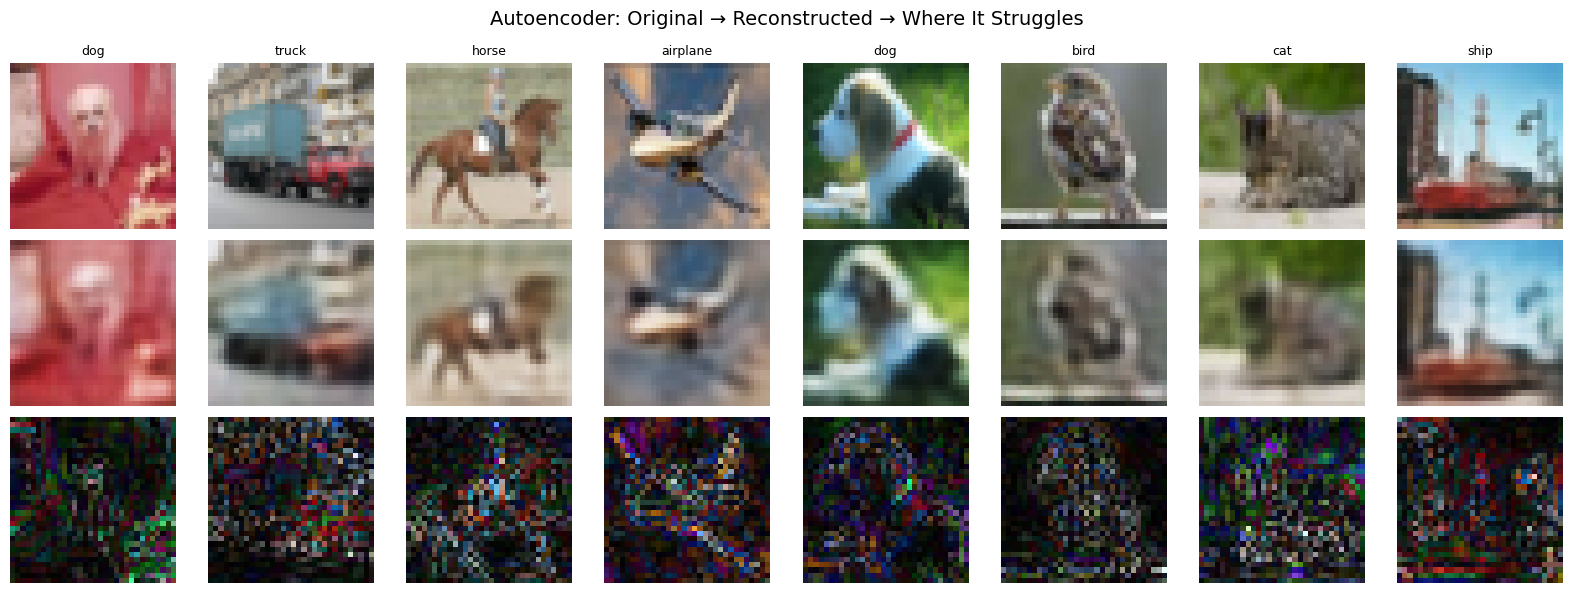

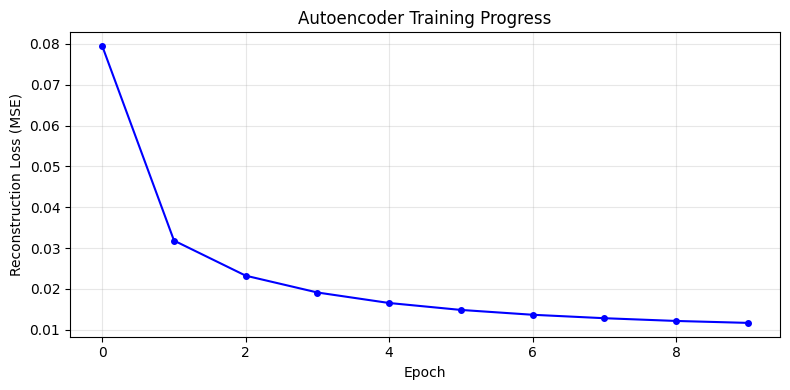

In [19]:
# =============================================================================
# Visualize Autoencoder Reconstructions
# =============================================================================

def unnormalize_tanh(img_tensor):
    """Convert from [-1,1] to [0,1] for visualization."""
    img = (img_tensor.cpu().detach().numpy() + 1) / 2.0
    return img.transpose(0, 2, 3, 1)

# Get a batch of images and their reconstructions
dataiter = iter(dataloader_gan)
images, labels = next(dataiter)
images = images.to(device)

with torch.no_grad():
    recon_images = autoencoder(images)
    latent_codes = autoencoder.encode(images)

orig_imgs = unnormalize_tanh(images)
recon_imgs = unnormalize_tanh(recon_images)

# Display original vs reconstructed
n = 8
fig, axes = plt.subplots(3, n, figsize=(16, 6))

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(n):
    # Original
    axes[0, i].imshow(np.clip(orig_imgs[i], 0, 1))
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Original', fontsize=12, fontweight='bold')
    axes[0, i].set_title(cifar_classes[labels[i]], fontsize=9)
    
    # Reconstructed
    axes[1, i].imshow(np.clip(recon_imgs[i], 0, 1))
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Reconstructed', fontsize=12, fontweight='bold')
    
    # Difference (error) map
    diff = np.abs(orig_imgs[i] - recon_imgs[i])
    axes[2, i].imshow(diff / diff.max())  # Normalize for visibility
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel('Error Map', fontsize=12, fontweight='bold')

plt.suptitle('Autoencoder: Original → Reconstructed → Where It Struggles', fontsize=14)
plt.tight_layout()
plt.show()

# Plot the training loss curve
plt.figure(figsize=(8, 4))
plt.plot(ae_losses, 'b-o', markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss (MSE)')
plt.title('Autoencoder Training Progress')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 🧪 Experiment 2: What Does the Latent Space Capture?

Let's investigate what information the autoencoder preserves in its compressed representation. We'll look at whether similar images end up close together in latent space.

Running t-SNE dimensionality reduction (this may take a moment)...


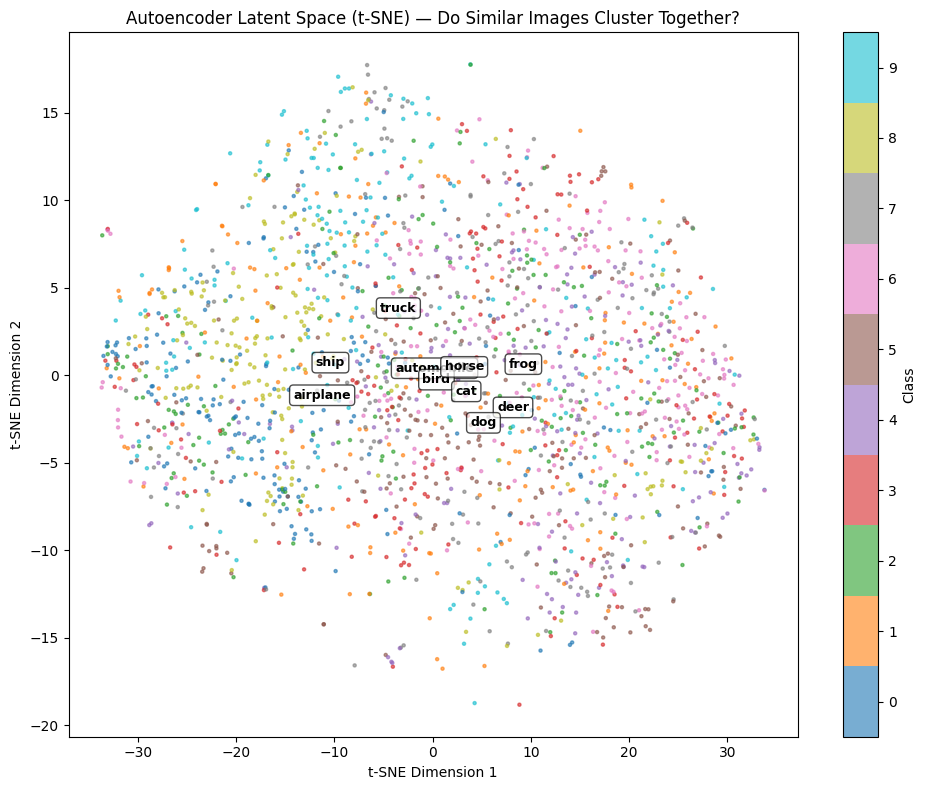

In [20]:
# =============================================================================
# 🧪 EXPERIMENT: Visualizing the Latent Space with t-SNE
# =============================================================================
from sklearn.manifold import TSNE

# Collect latent codes for a subset of test images
all_latents = []
all_labels_ae = []

autoencoder.eval()
with torch.no_grad():
    for data in dataloader_gan:
        images, labels_batch = data
        images = images.to(device)
        latent = autoencoder.encode(images)
        all_latents.append(latent.cpu().numpy())  # Already a flat vector thanks to the linear bottleneck
        all_labels_ae.append(labels_batch.numpy())
        if len(all_latents) * 128 > 2000:  # Use ~2000 samples for speed
            break

all_latents = np.concatenate(all_latents, axis=0)[:2000]
all_labels_ae = np.concatenate(all_labels_ae, axis=0)[:2000]

# Apply t-SNE to reduce to 2D
print("Running t-SNE dimensionality reduction (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(all_latents)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                      c=all_labels_ae, cmap='tab10', s=5, alpha=0.6)
plt.colorbar(scatter, ticks=range(10), label='Class')
plt.clim(-0.5, 9.5)
plt.title('Autoencoder Latent Space (t-SNE) — Do Similar Images Cluster Together?')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Add class labels
for i, name in enumerate(cifar_classes):
    mask = all_labels_ae == i
    if mask.sum() > 0:
        cx, cy = latents_2d[mask].mean(axis=0)
        plt.annotate(name, (cx, cy), fontsize=9, fontweight='bold',
                    ha='center', va='center',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

### 🟡 Reflection 6: Autoencoder Deep Dive

1. **Reconstruction quality**: Look at the original vs. reconstructed images and the error maps. Which types of details does the autoencoder struggle with? (edges? colors? textures? fine details?) Why do you think this is?

*Your answer:*
When I compare the original images to the reconstructions and look at the error maps, I notice that the autoencoder tends to struggle most with fine details and sharp edges. Large, smooth regions—like broad areas of background color or big simple shapes—are usually captured fairly well, but thin lines, texture patterns, and tiny high‑frequency details often get washed out or slightly misplaced. I think this happens because the bottleneck forces the network to keep only the most important, compressed information about the image, so it prioritizes global structure and overall color over pixel‑perfect detail. On top of that, the convolutional layers and pooling/striding naturally bias the model toward capturing coarse features at the expense of very local, high‑resolution patterns, which shows up as errors around edges and textures.

2. **The blurriness problem**: Autoencoder reconstructions are often blurrier than the originals. This is because MSE loss penalizes pixel-level errors, which encourages the network to predict "average" values. How might GANs avoid this problem?

*Your answer:*
The blurriness in the reconstructions makes sense once I think about the effect of MSE loss. Since MSE penalizes the squared difference between predicted and true pixel values, the safest strategy for the autoencoder is often to output something like an “average” of plausible possibilities. Whenever there is uncertainty about the exact texture or small details, predicting an average leads to smoother, blurrier results rather than crisp, high‑contrast features. GANs can avoid this problem because they don’t just try to minimize per‑pixel error; instead, the generator is trained to produce images that the discriminator cannot distinguish from real ones. That adversarial feedback pushes the generator to match higher‑level statistics and realistic textures, rewarding sharp edges and detailed structure rather than averaged‑out pixels. In other words, the discriminator acts as a learned perceptual loss that encourages realism instead of pixel‑wise averaging.


3. **Latent space structure**: Look at your t-SNE plot. Do images of the same class cluster together? What does this tell you about what the autoencoder has learned beyond just pixel reconstruction?

*Your answer:*
Looking at the t‑SNE plot of the latent representations, I pay attention to whether images from the same class tend to cluster together. If I see that, for example, cars are mostly grouped in one region and ships in another, that tells me the autoencoder has learned more than just a way to copy pixels—it has actually captured semantic structure in the latent space. That means the encoder is mapping images into a space where similar images (in terms of content) are close to each other, even though the training objective was just reconstruction. This suggests that the model is discovering meaningful features that relate to object identity, shapes, and patterns, and those features could be useful for other tasks like classification, clustering, or anomaly detection.

4. **Compression trade-off**: We compressed 3,072 pixel values into just 256 latent values (12× compression). What would happen if we used an even tighter bottleneck (e.g., `latent_dim=32`)? What about a larger one (`latent_dim=1024`)? Try changing `latent_dim` in the Autoencoder constructor and retraining — describe what you observe.

*Your answer:*
The compression trade‑off becomes clear when I think about changing the size of the latent bottleneck. With the current setup, we compress 3,072 pixel values down to 256 latent values, which already forces the autoencoder to be selective. If I reduce latent_dim to something like 32, the bottleneck gets much tighter, so the model is likely to lose more information: reconstructions will probably become blurrier, with more missing fine details and maybe even distortions in object shapes, but the latent space might capture very high‑level factors in a more compact way. On the other hand, if I increase latent_dim to 1024, the autoencoder has more capacity to store information, so reconstructions should look sharper and closer to the originals, with better preservation of details. The trade‑off is that the representation becomes less compressed and might include more “raw” information rather than distilled, abstract features. By experimenting with different latent dimensions, I can see how pushing the bottleneck harder forces the network to focus on only the most essential structure in the data, while a wider bottleneck moves it closer to just memorizing the input.

---

# 🔴 Advanced Challenges: Push Your Limits!

You've mastered the fundamentals of GANs and Autoencoders. Now it's time to explore deeper and see the real power of these architectures!

**Grading**: Complete at least 2 challenges. You'll be graded on effort, thoughtfulness, and the insights you document — not just whether the code runs perfectly.

## 🔴 Challenge 1: Denoising Autoencoder — Cleaning Corrupted Images

**Real-world application**: Medical imaging, satellite photography, old photo restoration

**Goal**: Modify your autoencoder to *remove noise* from corrupted images. Instead of learning to reconstruct clean images from clean inputs, train it to reconstruct clean images from *noisy* inputs.

**Your Mission**:
1. Add Gaussian noise to input images (but keep the targets clean)
2. Train the autoencoder on noisy→clean pairs
3. Visualize: noisy input → denoised output → original clean image
4. Experiment with different noise levels

**Target**: Denoised images should be visibly cleaner than the noisy inputs

In [21]:
# =============================================================================
# 🔴 CHALLENGE 1: Denoising Autoencoder
# =============================================================================

def add_noise(images, noise_factor=0.3):
    """Add Gaussian noise to images."""
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy, -1, 1)  # Keep in valid range

# TODO: Train a denoising autoencoder
# Hint: In the training loop, create noisy versions of each batch
# and train the autoencoder to reconstruct the CLEAN originals from noisy inputs.
#
# denoising_ae = Autoencoder().to(device)
# criterion_denoise = nn.MSELoss()
# optimizer_denoise = optim.Adam(denoising_ae.parameters(), lr=0.001)
#
# for epoch in range(num_epochs):
#     for images, _ in dataloader_gan:
#         noisy_images = add_noise(images.to(device))
#         clean_images = images.to(device)
#         recon = denoising_ae(noisy_images)  # forward() handles encode→decode
#         loss = criterion_denoise(recon, clean_images)  # Note: loss against CLEAN images!
#         ...

# YOUR CODE HERE
# =============================================================================
# 🔴 CHALLENGE 1: Denoising Autoencoder
# =============================================================================

denoising_ae = Autoencoder().to(device)
criterion_denoise = nn.MSELoss()
optimizer_denoise = optim.Adam(denoising_ae.parameters(), lr=0.001)

num_epochs = 10
noise_factor = 0.3   # Try 0.1, 0.3, 0.5 later!

for epoch in range(num_epochs):
    denoising_ae.train()
    running_loss = 0.0

    for images, _ in dataloader_gan:
        images = images.to(device)

        # Create noisy inputs
        noisy_images = add_noise(images, noise_factor=noise_factor)

        # Forward pass: noisy → denoised
        recon = denoising_ae(noisy_images)

        # Compute loss against CLEAN images
        loss = criterion_denoise(recon, images)

        # Backpropagation
        optimizer_denoise.zero_grad()
        loss.backward()
        optimizer_denoise.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader_gan):.4f}")







Epoch [1/10], Loss: 0.0683
Epoch [2/10], Loss: 0.0337
Epoch [3/10], Loss: 0.0269
Epoch [4/10], Loss: 0.0238
Epoch [5/10], Loss: 0.0218
Epoch [6/10], Loss: 0.0205
Epoch [7/10], Loss: 0.0195
Epoch [8/10], Loss: 0.0187
Epoch [9/10], Loss: 0.0182
Epoch [10/10], Loss: 0.0177


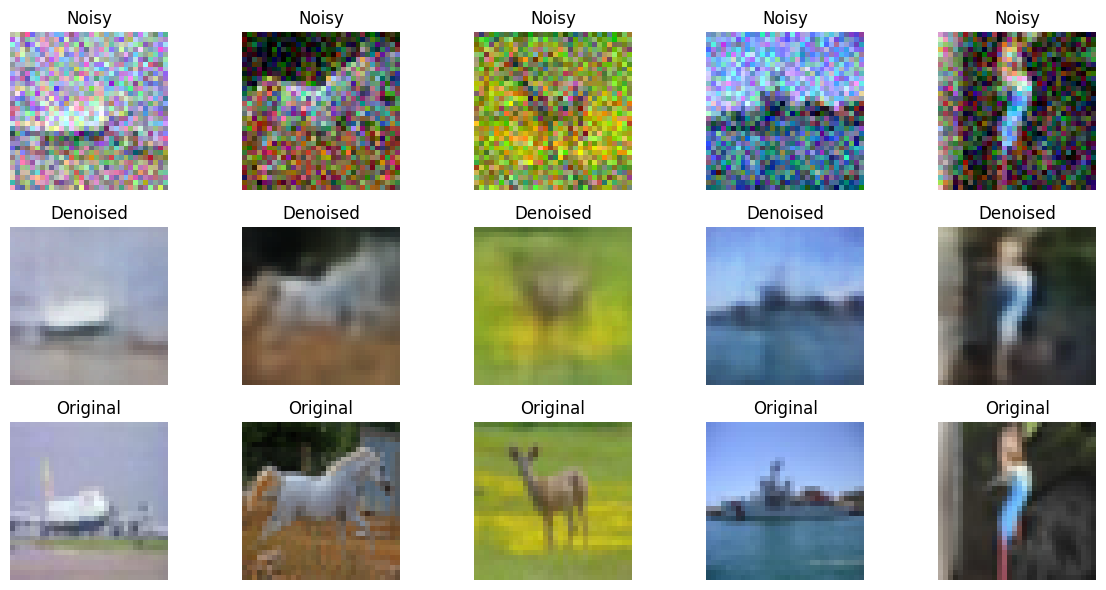

In [22]:
# Visualize results: noisy → denoised → original
# YOUR VISUALIZATION HERE
import matplotlib.pyplot as plt

denoising_ae.eval()

# Get a batch of test images
images, _ = next(iter(dataloader_gan))
images = images.to(device)

# Add noise
noisy_images = add_noise(images, noise_factor=noise_factor)

# Denoise
with torch.no_grad():
    denoised_images = denoising_ae(noisy_images)

# Move to CPU for plotting
images = images.cpu()
noisy_images = noisy_images.cpu()
denoised_images = denoised_images.cpu()

# Plot first 5 images
n = 5
plt.figure(figsize=(12, 6))

for i in range(n):
    # Noisy
    plt.subplot(3, n, i+1)
    plt.imshow(noisy_images[i].permute(1,2,0) * 0.5 + 0.5)
    plt.title("Noisy")
    plt.axis("off")

    # Denoised
    plt.subplot(3, n, i+1+n)
    plt.imshow(denoised_images[i].permute(1,2,0) * 0.5 + 0.5)
    plt.title("Denoised")
    plt.axis("off")

    # Clean
    plt.subplot(3, n, i+1+2*n)
    plt.imshow(images[i].permute(1,2,0) * 0.5 + 0.5)
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 🔴 Challenge 2: Conditional Generation — Controlling What the GAN Creates

**Real-world application**: Text-to-image generation, controlled content creation

**Goal**: Modify the GAN so you can tell it *which class* of image to generate. Instead of random images, generate specific categories (e.g., "generate a car" or "generate a bird").

**Your Mission**:
1. Modify the Generator to accept a class label alongside the noise vector
2. Modify the Discriminator to also receive the class label
3. Train the conditional GAN
4. Generate images of specific classes on demand

**Hint**: Concatenate a one-hot encoded class label to the noise vector for the Generator, and add it as an extra channel for the Discriminator.

Using device: cpu
Files already downloaded and verified
Epoch [1/10] | Loss_D: 0.4397 | Loss_G: 4.0799
Epoch [2/10] | Loss_D: 1.4229 | Loss_G: 2.2938
Epoch [3/10] | Loss_D: 1.2083 | Loss_G: 1.3583
Epoch [4/10] | Loss_D: 1.7511 | Loss_G: 1.0163
Epoch [5/10] | Loss_D: 1.2067 | Loss_G: 1.0514
Epoch [6/10] | Loss_D: 1.2213 | Loss_G: 1.1764
Epoch [7/10] | Loss_D: 1.3319 | Loss_G: 1.0794
Epoch [8/10] | Loss_D: 1.1968 | Loss_G: 1.3686
Epoch [9/10] | Loss_D: 1.2687 | Loss_G: 1.2550
Epoch [10/10] | Loss_D: 1.3141 | Loss_G: 1.0465


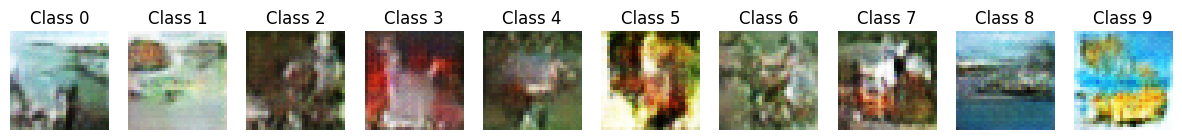

In [43]:
# =============================================================================
# 🔴 CHALLENGE 2: Conditional GAN (cGAN)
# =============================================================================

# Hint: One approach is to embed class labels and concatenate with noise/images
#
# class ConditionalGenerator(nn.Module):
#     def __init__(self, nz, num_classes=10):
#         super().__init__()
#         self.label_embed = nn.Embedding(num_classes, num_classes)
#         # Modify the first layer to accept nz + num_classes channels
#         ...
#
# class ConditionalDiscriminator(nn.Module):
#     def __init__(self, num_classes=10):
#         super().__init__()
#         self.label_embed = nn.Embedding(num_classes, 32*32)
#         # Modify the first layer to accept 3 + 1 channels (image + label map)
#         ...

# YOUR CODE HERE

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Hyperparameters
# ----------------------------
nz = 100          # Noise vector
num_classes = 10  # CIFAR-10
ngf = 64          # Generator feature maps
ndf = 64          # Discriminator feature maps
num_epochs = 10   # For demo (increase for better quality)
batch_size = 128
lr = 0.0002
beta1 = 0.5

# ----------------------------
# Dataset & Dataloader
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader_gan = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

# ----------------------------
# Conditional Generator
# ----------------------------
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, num_classes=10, ngf=64, nc=3):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        input_dim = nz + num_classes
        self.net = nn.Sequential(
            nn.Linear(input_dim, ngf*8*4*4),
            nn.BatchNorm1d(ngf*8*4*4),
            nn.ReLU(True),
            nn.Unflatten(1, (ngf*8, 4, 4)),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.Conv2d(ngf, nc, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        return self.net(x)

# ----------------------------
# Conditional Discriminator
# ----------------------------
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10, ndf=64, nc=3):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, 32*32)
        self.net = nn.Sequential(
            nn.Conv2d(nc+1, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label_map = self.label_embed(labels).view(batch_size, 1, 32, 32)
        x = torch.cat([img, label_map], dim=1)
        return self.net(x).view(-1)

# ----------------------------
# Initialize models
# ----------------------------
G = ConditionalGenerator(nz, num_classes).to(device)
D = ConditionalDiscriminator(num_classes).to(device)

criterion = nn.BCELoss()
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

real_label = 1.
fake_label = 0.

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_gan):
        batch_size_curr = images.size(0)
        images, labels = images.to(device), labels.to(device)

        # --- Train Discriminator ---
        D.zero_grad()
        output_real = D(images, labels)
        loss_real = criterion(output_real, torch.full((batch_size_curr,), real_label, device=device))

        noise = torch.randn(batch_size_curr, nz, device=device)
        fake_images = G(noise, labels)
        output_fake = D(fake_images.detach(), labels)
        loss_fake = criterion(output_fake, torch.full((batch_size_curr,), fake_label, device=device))

        lossD = loss_real + loss_fake
        lossD.backward()
        optimizerD.step()

        # --- Train Generator ---
        G.zero_grad()
        output_fake = D(fake_images, labels)
        lossG = criterion(output_fake, torch.full((batch_size_curr,), real_label, device=device))
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss_D: {lossD.item():.4f} | Loss_G: {lossG.item():.4f}")

# ----------------------------
# Generate Images of Specific Classes
# ----------------------------
G.eval()
n_samples = 10
classes_to_generate = list(range(10))  # CIFAR-10: 0–9

noise = torch.randn(n_samples, nz, device=device)
labels = torch.tensor(classes_to_generate, device=device)
with torch.no_grad():
    generated_imgs = G(noise, labels).cpu()

plt.figure(figsize=(15,3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(generated_imgs[i].permute(1,2,0) * 0.5 + 0.5)
    plt.title(f"Class {classes_to_generate[i]}")
    plt.axis("off")
plt.show()


# Generate images of specific classes
# YOUR VISUALIZATION HERE



## 🔴 Challenge 3: Variational Autoencoder (VAE) — The Best of Both Worlds

**Real-world application**: Drug molecule generation, music composition, data augmentation

**Goal**: Convert your autoencoder into a **Variational Autoencoder** by adding a probabilistic latent space. Unlike regular autoencoders, VAEs can *generate* new images (like GANs!) while also providing meaningful latent representations.

**Your Mission**:
1. Modify the encoder to output **mean** and **log-variance** vectors
2. Implement the **reparameterization trick** (z = μ + σ × ε)
3. Add **KL divergence** to the loss function
4. Generate new images by sampling from the latent space

**Target**: Generated images should look like plausible CIFAR-10 images

In [ ]:
# =============================================================================
# 🔴 CHALLENGE 3: Variational Autoencoder (VAE)
# =============================================================================

# Hint: The key modifications are:
#
# 1. Encoder outputs mu and log_var (two separate linear layers)
# 2. Reparameterization trick:
#    def reparameterize(self, mu, log_var):
#        std = torch.exp(0.5 * log_var)
#        eps = torch.randn_like(std)
#        return mu + eps * std
#
# 3. Loss = Reconstruction Loss + KL Divergence
#    KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

# YOUR CODE HERE



# Generate new images by sampling from the latent space
# YOUR VISUALIZATION HERE

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ----------------------------
# Device
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------
# Hyperparameters
# ----------------------------
nz = 100          # Noise vector
num_classes = 10  # CIFAR-10
ngf = 64          # Generator feature maps
ndf = 64          # Discriminator feature maps
num_epochs = 10   # For demo (increase for better quality)
batch_size = 128
lr = 0.0002
beta1 = 0.5

# ----------------------------
# Dataset & Dataloader
# ----------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
dataloader_gan = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

# ----------------------------
# Conditional Generator
# ----------------------------
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, num_classes=10, ngf=64, nc=3):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, num_classes)
        input_dim = nz + num_classes
        self.net = nn.Sequential(
            nn.Linear(input_dim, ngf*8*4*4),
            nn.BatchNorm1d(ngf*8*4*4),
            nn.ReLU(True),
            nn.Unflatten(1, (ngf*8, 4, 4)),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.Conv2d(ngf, nc, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embedding = self.label_embed(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        return self.net(x)

# ----------------------------
# Conditional Discriminator
# ----------------------------
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10, ndf=64, nc=3):
        super().__init__()
        self.label_embed = nn.Embedding(num_classes, 32*32)
        self.net = nn.Sequential(
            nn.Conv2d(nc+1, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, 1, 4, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label_map = self.label_embed(labels).view(batch_size, 1, 32, 32)
        x = torch.cat([img, label_map], dim=1)
        return self.net(x).view(-1)

# ----------------------------
# Initialize models
# ----------------------------
G = ConditionalGenerator(nz, num_classes).to(device)
D = ConditionalDiscriminator(num_classes).to(device)

criterion = nn.BCELoss()
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

real_label = 1.
fake_label = 0.

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader_gan):
        batch_size_curr = images.size(0)
        images, labels = images.to(device), labels.to(device)

        # --- Train Discriminator ---
        D.zero_grad()
        output_real = D(images, labels)
        loss_real = criterion(output_real, torch.full((batch_size_curr,), real_label, device=device))

        noise = torch.randn(batch_size_curr, nz, device=device)
        fake_images = G(noise, labels)
        output_fake = D(fake_images.detach(), labels)
        loss_fake = criterion(output_fake, torch.full((batch_size_curr,), fake_label, device=device))

        lossD = loss_real + loss_fake
        lossD.backward()
        optimizerD.step()

        # --- Train Generator ---
        G.zero_grad()
        output_fake = D(fake_images, labels)
        lossG = criterion(output_fake, torch.full((batch_size_curr,), real_label, device=device))
        lossG.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss_D: {lossD.item():.4f} | Loss_G: {lossG.item():.4f}")

# ----------------------------
# Generate Images of Specific Classes
# ----------------------------
G.eval()
n_samples = 10
classes_to_generate = list(range(10))  # CIFAR-10: 0–9

noise = torch.randn(n_samples, nz, device=device)
labels = torch.tensor(classes_to_generate, device=device)
with torch.no_grad():
    generated_imgs = G(noise, labels).cpu()

plt.figure(figsize=(15,3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(generated_imgs[i].permute(1,2,0) * 0.5 + 0.5)
    plt.title(f"Class {classes_to_generate[i]}")
    plt.axis("off")
plt.show()



RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 80 but got size 10 for tensor number 1 in the list.

## 🔴 Challenge 4: Anomaly Detection with Autoencoders

**Real-world application**: Fraud detection, manufacturing quality control, medical diagnosis

**Goal**: Use your trained autoencoder as an **anomaly detector**. The key insight: an autoencoder trained on "normal" data will have high reconstruction error on "abnormal" data because it hasn't learned to represent those patterns.

**Your Mission**:
1. Train an autoencoder on only ONE class of CIFAR-10 (e.g., only airplanes)
2. Test it on ALL classes
3. Images from the trained class should have LOW reconstruction error
4. Images from other classes should have HIGH reconstruction error
5. Visualize the reconstruction error distribution for each class

**Target**: Clear separation between the "normal" class and "anomalous" classes

In [ ]:
# =============================================================================
# 🔴 CHALLENGE 4: Anomaly Detection
# =============================================================================

# Hint: 
# 1. Filter the dataset to only include one class:
#    normal_class = 0  # airplane
#    indices = [i for i, (_, label) in enumerate(dataset_gan) if label == normal_class]
#    normal_dataset = torch.utils.data.Subset(dataset_gan, indices)
#
# 2. Train the autoencoder on this filtered dataset
#
# 3. Compute reconstruction error for each class:
#    errors_by_class = {i: [] for i in range(10)}
#    for images, labels in test_loader:
#        recon = autoencoder(images)
#        per_sample_error = ((images - recon) ** 2).mean(dim=[1,2,3])
#        for err, label in zip(per_sample_error, labels):
#            errors_by_class[label.item()].append(err.item())

# YOUR CODE HERE



# Visualize reconstruction error distribution by class
# YOUR VISUALIZATION HERE



## 🔴 Challenge 5: GAN Training Stability — Experiment and Diagnose

**Real-world application**: Understanding training dynamics is crucial for any generative AI work

**Goal**: Systematically explore what makes GAN training stable or unstable, and document your findings like a researcher.

**Your Mission**: Try at least 3 of these experiments and document what happens:

1. **Unbalanced learning rates**: Set D's learning rate to 10× the G's learning rate. What happens?
2. **Remove BatchNorm**: Train the GAN without BatchNorm in either network. How does it affect convergence?
3. **Different latent dimensions**: Try nz=10, nz=100, nz=500. How does it affect image quality?
4. **Label smoothing**: Instead of labels 0.0 and 1.0, use 0.1 and 0.9. Does this help?
5. **One-sided label smoothing**: Only smooth the real labels (0.9 instead of 1.0), keep fake at 0.0

**Target**: Document your findings with loss curves and generated image comparisons

In [ ]:
# =============================================================================
# 🔴 CHALLENGE 5: GAN Training Stability Experiments
# =============================================================================

# Document which experiments you tried and what you observed

# Experiment: _______________
# Hypothesis: _______________
# Result: _______________

# YOUR CODE HERE



# YOUR VISUALIZATIONS AND ANALYSIS HERE



## 🔴 Challenge 6: Autoencoder for Image Interpolation

**Real-world application**: Morphing effects, data augmentation, creative tools

**Goal**: Use the autoencoder's latent space to smoothly morph between two real images. Encode both images, interpolate in latent space, then decode the interpolated representations.

**Your Mission**:
1. Encode two different CIFAR-10 images into latent codes
2. Create a smooth interpolation between the two latent codes
3. Decode each interpolated point back to an image
4. Display the full morphing sequence
5. Try morphing between different class pairs (e.g., car→airplane, dog→cat)

**Target**: Smooth, visually pleasing transitions between images

In [ ]:
# =============================================================================
# 🔴 CHALLENGE 6: Image Interpolation via Latent Space
# =============================================================================

# Hint:
# 1. Get two images: img1, img2
# 2. Encode both: z1 = autoencoder.encode(img1), z2 = autoencoder.encode(img2)
# 3. Interpolate: z_interp = (1-alpha)*z1 + alpha*z2 for alpha in [0, 0.1, ..., 1.0]
# 4. Decode each: recon = autoencoder.decode(z_interp)
# 5. Display the sequence

# YOUR CODE HERE



# YOUR VISUALIZATION HERE



---

# 🎓 Final Reflection: Your Generative Modeling Journey

Congratulations! You've explored two of the most powerful paradigms in deep learning. Take a moment to reflect on what you've learned.

### 🟡 Final Reflection Questions

1. **Biggest Insight**: What was your biggest "aha!" moment in this lab? Was there something about GANs or autoencoders that surprised you?

*Your answer:*


2. **GANs vs. Autoencoders**: In your own words, explain the fundamental difference between how GANs and autoencoders learn to generate/reconstruct images. When would you choose one over the other?

*Your answer:*


3. **The Adversarial Principle**: The GAN training process is sometimes described as a "minimax game." Explain what this means and why it leads to a network that can generate realistic images.

*Your answer:*


4. **Practical Skills**: What practical skills did you gain from this lab that you could apply to other deep learning problems?

*Your answer:*


5. **Real-World Applications**: Pick one real-world application of generative models (medical imaging, art, data augmentation, etc.) and describe how you would apply what you learned in this lab.

*Your answer:*


## 📚 What You've Accomplished

✅ Built and trained a CNN classifier with advanced visualization (Grad-CAM)
✅ Implemented a DCGAN Generator and Discriminator from scratch
✅ Trained a GAN and observed the adversarial training dynamics
✅ Explored latent space interpolation in GANs
✅ Built and trained a Convolutional Autoencoder
✅ Visualized reconstruction quality and error patterns
✅ Explored the autoencoder's latent space with t-SNE
✅ Tackled advanced challenges in generative modeling

## 🚀 Where to Go From Here

1. **Variational Autoencoders (VAEs)**: Bridge the gap between autoencoders and GANs
2. **StyleGAN / StyleGAN2**: State-of-the-art in high-resolution image generation
3. **Diffusion Models**: The architecture behind DALL-E 2 and Stable Diffusion
4. **CycleGAN**: Unpaired image-to-image translation (horses↔zebras!)
5. **Neural Radiance Fields (NeRF)**: 3D scene generation from 2D images

## 🌟 Remember

> "The most exciting phrase to hear in science, the one that heralds new discoveries, is not 'Eureka!' but 'That's funny...'" — Isaac Asimov

The best insights in generative modeling come from careful observation and curiosity. Keep experimenting, keep visualizing, keep asking "why?"

---

**Happy Learning! 🎉**